# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

# 1 
**We first try L1Loss () as a loss function：**

In [8]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.L1Loss()
###############################################################

In [9]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    num_classes = 10
    targets = torch.nn.functional.one_hot(target, num_classes)
    targets = targets.float()
    loss = criterion(output,targets)
    ###############################################################

    return output, loss

In [10]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    num_classes = 10
    targets = torch.nn.functional.one_hot(target, num_classes)
    targets = targets.float()
    loss = criterion(output,targets)
    ###############################################################

    return output, loss

While running the code, I find that the corresponding input is a tensor of Size(torch.Size([128, 10])), but the corresponding target is a tensor of Size(torch.Size([128])). And the following error message appears:

<span style="color: red;">*/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)*</span>

It reminds us that the size of the input tensor and the size of the target tensor need to be modified to be the same. At first I tried to use the following methods (these changes are very crude and illogical)：

**1**：

target = target.view(batch_size, 10)
This method forced the expansion of the target tensor, but was rejected because it did not have a sufficient number of elements and was very illogical.

**2**：

target = target.repeat(10, 1)
target = target.transport(0,1)
This method forcibly expands the target tensor, but the generated tensor just blindly copies the elements of the original target tensor 10 times, which is completely meaningless

So after I called print () and looked at the contents of the input tensor and the target tensor, I came up with one hot encoding mentioned in class.
But since the input tensor is in floating-point form, and the result of one hot encoding is in integer form, I converted it so that they can match, and finally entered the model training, you can see the following result:

### Model Training

In [11]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
              
        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0009 Acc: 0.1008
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.1003
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.0999
Begin test......
Test Loss: 0.0008 Acc: 0.1000
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.1004
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Epoch: 5/30 Train Loss: 0.0009 Acc: 0.1002
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.0986
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.1002
Begin test......
Test Loss: 0.0008 Acc: 0.1000
Epoch: 8/30 Train Loss: 0.0008 Acc: 0.0988
Begin test......
Test Loss: 0.0008 Acc: 0.1000
Epoch: 9/30 Train Loss: 0.0008 Acc: 0.0999
Begin test......
Test Loss: 0.0008 Acc: 0.1000
Epoch: 10/30 Train Loss: 0.0008 Acc: 0.1023
Begin test......
Test Loss: 0.0008 Acc: 0.1000
Epoch: 11/30 Train Loss: 0.0008 Acc: 0.0995
Begin test......
Test Loss: 0.0008 Acc: 0.1000
Epoch: 1

As we can see, when we use L1Loss () as a loss function, the loss value on both the training set and the test set is relatively small, but the accuracy of the test is generally around 10%, which is not very ideal.

We can visualize the information by constructing a line chart:

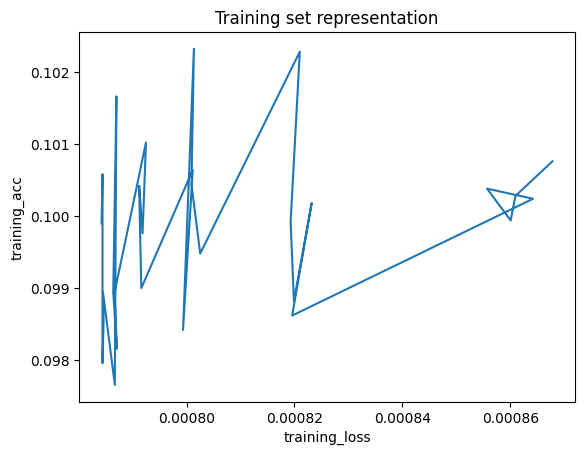

In [12]:
import matplotlib.pyplot as plt

plt.plot(training_loss, training_acc)
plt.title('Training set representation')
plt.xlabel('training_loss')
plt.ylabel('training_acc')
plt.show()

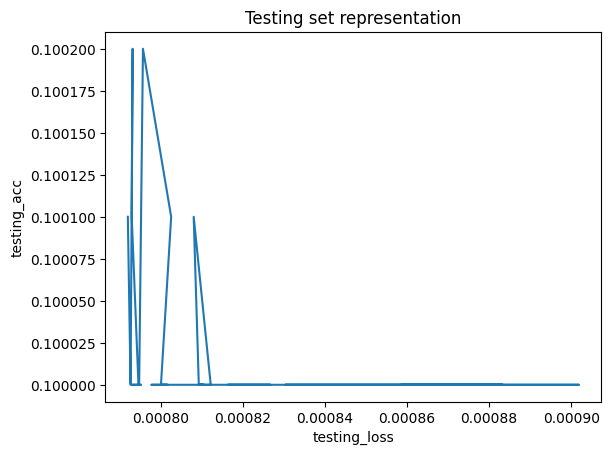

In [13]:
import matplotlib.pyplot as plt

plt.plot(testing_loss, testing_acc)
plt.title('Testing set representation')
plt.xlabel('testing_loss')
plt.ylabel('testing_acc')
plt.show()

We can note that the image is very cluttered and the L1loss is not very effective, which will be discussed later.

# 2
**Next we use CrossEntropyLoss() as the loss function:**

In [14]:
criterion2 = nn.CrossEntropyLoss()

In [15]:
def train_batch2(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion2(output,target)
    ###############################################################

    return output, loss

In [16]:
def test_batch2(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion2(output,target)
    ###############################################################

    return output, loss

In [17]:
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch2(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch2(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0155 Acc: 0.2574
Begin test......
Test Loss: 0.0150 Acc: 0.2960
Epoch: 2/30 Train Loss: 0.0144 Acc: 0.3165
Begin test......
Test Loss: 0.0137 Acc: 0.3536
Epoch: 3/30 Train Loss: 0.0139 Acc: 0.3399
Begin test......
Test Loss: 0.0133 Acc: 0.3691
Epoch: 4/30 Train Loss: 0.0137 Acc: 0.3500
Begin test......
Test Loss: 0.0134 Acc: 0.3640
Epoch: 5/30 Train Loss: 0.0137 Acc: 0.3509
Begin test......
Test Loss: 0.0129 Acc: 0.3848
Epoch: 6/30 Train Loss: 0.0128 Acc: 0.3938
Begin test......
Test Loss: 0.0121 Acc: 0.4357
Epoch: 7/30 Train Loss: 0.0126 Acc: 0.4064
Begin test......
Test Loss: 0.0121 Acc: 0.4447
Epoch: 8/30 Train Loss: 0.0125 Acc: 0.4126
Begin test......
Test Loss: 0.0119 Acc: 0.4403
Epoch: 9/30 Train Loss: 0.0124 Acc: 0.4168
Begin test......
Test Loss: 0.0118 Acc: 0.4513
Epoch: 10/30 Train Loss: 0.0123 Acc: 0.4198
Begin test......
Test Loss: 0.0119 Acc: 0.4475
Epoch: 11/30 Train Loss: 0.0117 Acc: 0.4482
Begin test......
Test Loss: 0.0110 Acc: 0.4871
Epoch: 1

Since we do not want to continue training the model on the original model, but instead replace the loss functions to see the difference in their training results, we need to re-initialize the model and create a new optimizer here.

The Cross-Entropy Loss function is commonly used in classification tasks, where the output of the model is a probability distribution for different classes, and the goal is the actual class label. Although the output of the model is a probability distribution, the cross-entropy loss does not require the input and the target to be the same size. This is because the cross entropy loss function is calculated in a way that allows for the adaptation of different numbers of classes. And in the library also has the corresponding automatic adjustment mode.

Through the observation of the above results, we can find that when the cross entropy is used as the loss function, its accuracy is greatly improved, generally about 30% to 60%. Its loss is generally around 0.01.

We can visualize the information by constructing a line chart:

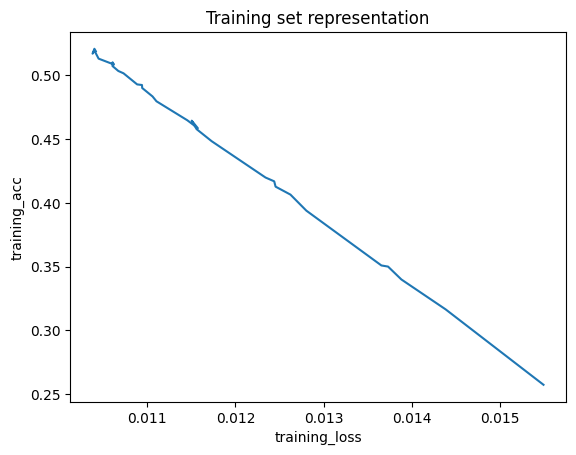

In [18]:
import matplotlib.pyplot as plt

plt.plot(training_loss, training_acc)
plt.title('Training set representation')
plt.xlabel('training_loss')
plt.ylabel('training_acc')
plt.show()

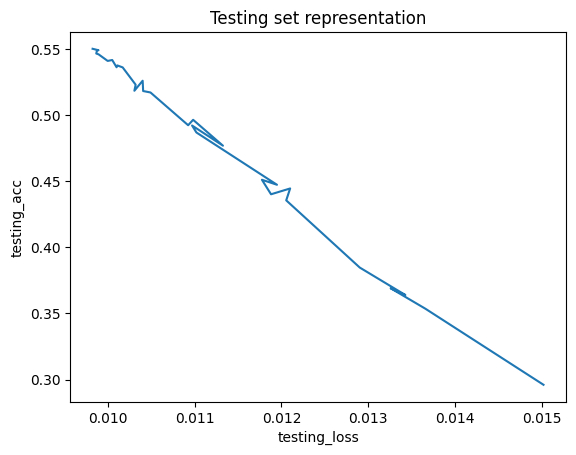

In [19]:
import matplotlib.pyplot as plt

plt.plot(testing_loss, testing_acc)
plt.title('Testing set representation')
plt.xlabel('testing_loss')
plt.ylabel('testing_acc')
plt.show()

# 3
**Now let's try using focal loss as a loss function and set gamma to 0.5:**

Here we rewrite the method using the formula definition of focal loss under multi-classification problem

In [20]:
def train_batch3(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    import torch
    import torch.nn as nn

    class FocalLoss(nn.Module):
        def __init__(self, num_classes, gamma=0.5):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.num_classes = num_classes

        def forward(self, inputdata, target):
            probs = torch.softmax(inputdata, dim=1)
            targets = torch.nn.functional.one_hot(target, num_classes)
            targets = targets.float()
            focal_loss = -((1 - probs) ** self.gamma) * targets * torch.log(probs)
            return focal_loss.mean()
    
    num_classes = 10    
    output = model(image)
    focal_loss = FocalLoss(num_classes, gamma=0.5)
    loss = focal_loss(output, target)
    ###############################################################

    return output, loss

In [21]:
def test_batch3(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    import torch
    import torch.nn as nn

    class FocalLoss(nn.Module):
        def __init__(self, num_classes, gamma=0.5):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.num_classes = num_classes

        def forward(self, inputdata, target):
            probs = torch.softmax(inputdata, dim=1)
            targets = torch.nn.functional.one_hot(target, num_classes)
            targets = targets.float()
            focal_loss = -((1 - probs) ** self.gamma) * targets * torch.log(probs)
            return focal_loss.mean()
    
    num_classes = 10    
    output = model(image)
    focal_loss = FocalLoss(num_classes, gamma=0.5)
    loss = focal_loss(output, target)
    ###############################################################

    return output, loss

In [22]:
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch3(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch3(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0014 Acc: 0.2976
Begin test......
Test Loss: 0.0012 Acc: 0.4022
Epoch: 2/30 Train Loss: 0.0012 Acc: 0.4032
Begin test......
Test Loss: 0.0010 Acc: 0.4674
Epoch: 3/30 Train Loss: 0.0011 Acc: 0.4292
Begin test......
Test Loss: 0.0010 Acc: 0.4805
Epoch: 4/30 Train Loss: 0.0010 Acc: 0.4544
Begin test......
Test Loss: 0.0009 Acc: 0.5157
Epoch: 5/30 Train Loss: 0.0010 Acc: 0.4671
Begin test......
Test Loss: 0.0009 Acc: 0.5235
Epoch: 6/30 Train Loss: 0.0010 Acc: 0.4929
Begin test......
Test Loss: 0.0009 Acc: 0.5486
Epoch: 7/30 Train Loss: 0.0010 Acc: 0.4956
Begin test......
Test Loss: 0.0009 Acc: 0.5466
Epoch: 8/30 Train Loss: 0.0010 Acc: 0.4996
Begin test......
Test Loss: 0.0009 Acc: 0.5467
Epoch: 9/30 Train Loss: 0.0010 Acc: 0.5043
Begin test......
Test Loss: 0.0009 Acc: 0.5588
Epoch: 10/30 Train Loss: 0.0009 Acc: 0.5171
Begin test......
Test Loss: 0.0009 Acc: 0.5642
Epoch: 11/30 Train Loss: 0.0009 Acc: 0.5261
Begin test......
Test Loss: 0.0008 Acc: 0.5655
Epoch: 1

We can visualize the information by constructing a line chart:

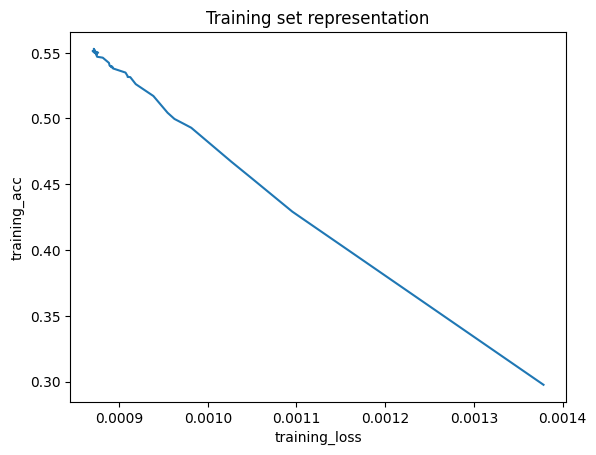

In [23]:
import matplotlib.pyplot as plt

plt.plot(training_loss, training_acc)
plt.title('Training set representation')
plt.xlabel('training_loss')
plt.ylabel('training_acc')
plt.show()

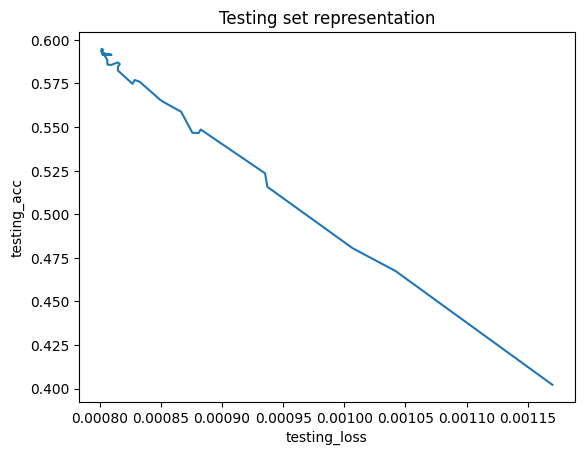

In [24]:
import matplotlib.pyplot as plt

plt.plot(testing_loss, testing_acc)
plt.title('Testing set representation')
plt.xlabel('testing_loss')
plt.ylabel('testing_acc')
plt.show()

We can see that focal loss performance is also very impressive when gamma is set at 0.5: loss is generally around 0.009, and accuracy ranges from 30% to 60%, with most remaining around 50%.

# 4
**Now let's try using focal loss as a loss function and set gamma to 2:**

In [25]:
def train_batch4(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    import torch
    import torch.nn as nn

    class FocalLoss(nn.Module):
        def __init__(self, num_classes, gamma=2):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.num_classes = num_classes

        def forward(self, inputdata, target):
            probs = torch.softmax(inputdata, dim=1)
            targets = torch.nn.functional.one_hot(target, num_classes)
            targets = targets.float()
            focal_loss = -((1 - probs) ** self.gamma) * targets * torch.log(probs)
            return focal_loss.mean()
    
    num_classes = 10    
    output = model(image)
    focal_loss = FocalLoss(num_classes, gamma=2)
    loss = focal_loss(output, target)
    ###############################################################

    return output, loss

In [26]:
def test_batch4(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    import torch
    import torch.nn as nn

    class FocalLoss(nn.Module):
        def __init__(self, num_classes, gamma=2):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.num_classes = num_classes

        def forward(self, inputdata, target):
            probs = torch.softmax(inputdata, dim=1)
            targets = torch.nn.functional.one_hot(target, num_classes)
            targets = targets.float()
            focal_loss = -((1 - probs) ** self.gamma) * targets * torch.log(probs)
            return focal_loss.mean()
    
    num_classes = 10    
    output = model(image)
    focal_loss = FocalLoss(num_classes, gamma=2)
    loss = focal_loss(output, target)
    ###############################################################

    return output, loss

In [27]:
model = ConvNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch4(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch4(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0011 Acc: 0.3031
Begin test......
Test Loss: 0.0009 Acc: 0.3954
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.4040
Begin test......
Test Loss: 0.0008 Acc: 0.4620
Epoch: 3/30 Train Loss: 0.0008 Acc: 0.4350
Begin test......
Test Loss: 0.0008 Acc: 0.4575
Epoch: 4/30 Train Loss: 0.0008 Acc: 0.4567
Begin test......
Test Loss: 0.0008 Acc: 0.4686
Epoch: 5/30 Train Loss: 0.0008 Acc: 0.4698
Begin test......
Test Loss: 0.0007 Acc: 0.5139
Epoch: 6/30 Train Loss: 0.0007 Acc: 0.4957
Begin test......
Test Loss: 0.0007 Acc: 0.5265
Epoch: 7/30 Train Loss: 0.0007 Acc: 0.5018
Begin test......
Test Loss: 0.0006 Acc: 0.5456
Epoch: 8/30 Train Loss: 0.0007 Acc: 0.5043
Begin test......
Test Loss: 0.0007 Acc: 0.5393
Epoch: 9/30 Train Loss: 0.0007 Acc: 0.5078
Begin test......
Test Loss: 0.0007 Acc: 0.5418
Epoch: 10/30 Train Loss: 0.0007 Acc: 0.5133
Begin test......
Test Loss: 0.0006 Acc: 0.5557
Epoch: 11/30 Train Loss: 0.0007 Acc: 0.5270
Begin test......
Test Loss: 0.0006 Acc: 0.5611
Epoch: 1

We can visualize the information by constructing a line chart:

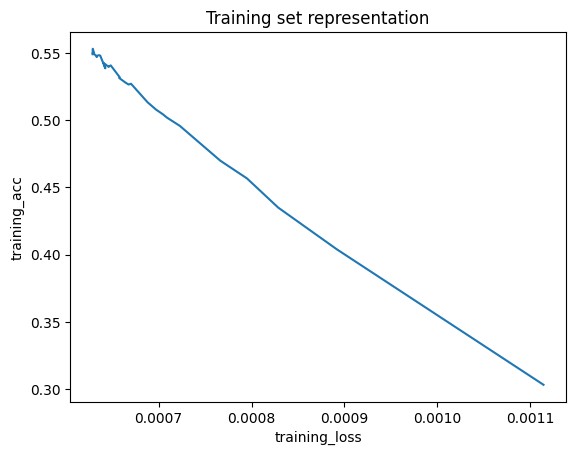

In [28]:
import matplotlib.pyplot as plt

plt.plot(training_loss, training_acc)
plt.title('Training set representation')
plt.xlabel('training_loss')
plt.ylabel('training_acc')
plt.show()

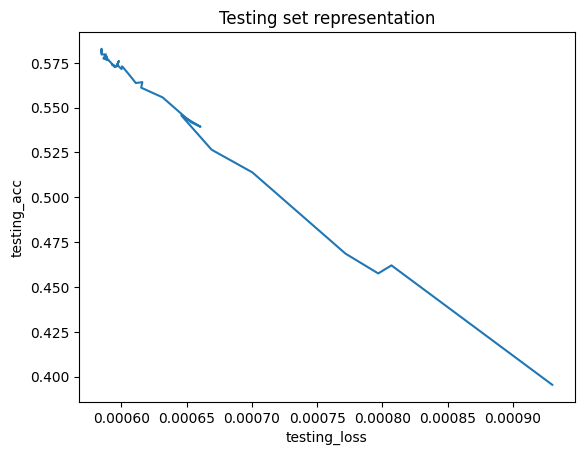

In [29]:
import matplotlib.pyplot as plt

plt.plot(testing_loss, testing_acc)
plt.title('Testing set representation')
plt.xlabel('testing_loss')
plt.ylabel('testing_acc')
plt.show()

We can see that focal loss seems to perform better when gamma is 2: loss is generally around 0.0007, while accuracy ranges from 30% to 60% and mostly stays around 55%.

# Results comparison and analysis

**Results comparison**

First of all, we can clearly see that L1loss is inferior to cross-entropy and focal loss.
As we can see, when we use L1Loss () as a loss function, the loss value on both the training set and the test set is relatively small, but the accuracy of the test is generally around 10%, which is not very ideal.
Secondly, cross-entropy does not perform as well as focal loss.
Through the observation of the above results of CE, we can find that when the cross entropy is used as the loss function, its accuracy is greatly improved, generally about 30% to 60%. Its loss is generally around 0.01.
We can see that focal loss performance is also very impressive: when gamma = 0.5, loss is generally around 0.009, and accuracy ranges from 30% to 60%, with most remaining around 50%. When gamma = 2, we can see that focal loss seems to perform better: loss is generally around 0.0007, while accuracy ranges from 30% to 60% and mostly stays around 55%.

**analysis**

**Question1:Why did L1loss perform so poorly?**

**Answer:**
L1 Loss is a commonly used loss function in regression problems, which is used to measure the absolute difference between the predicted value and the actual value of the model. It does not apply to the classification problem in this assignment, so it performs poorly.

**Question2:Why does cross entropy not perform as well as focal loss?**

**Answer:**
First, the cross-entropy loss may be affected in the class imbalance problem because it imposes the same penalty for misclassification of all classes. In the case of unbalanced categories, the model may be more inclined to predict categories that are in the majority, resulting in poor classification performance for a few categories. Focal Loss introduces an adjustable parameter (γ), which can reduce the weight of easy to classify samples and increase the weight of difficult to classify samples, so as to better deal with class imbalances.
Second, traditional cross-entropy Loss penalizes samples that are easy to classify (those with high confidence) less, whereas Focal Loss penalizes these samples relatively more. This means that the model may perform better on easily classified samples, while paying more attention to hard-to-classify samples, which helps improve overall performance. Focal Loss is designed so that the model is more focused on difficult samples, which helps the model better locate and learn important features in the data.
There may be a class imbalance in the data for this job, because when you call the print () method to look at the target tensor, you can see that it actually has only 7 different elements, but the size is 10 classes. So the performance of focal loss is better than that of normal cross entropy.

**Question3：Why is the accuracy slightly higher for test sets than for training sets?**

In general, the accuracy of the training set should be higher than that of the test set, because the model is trained on the training set, and it will try to fit the patterns and features in the training data, so it will perform better on the training set.

Ideally, the model should behave similarly on the test set as it does on the training set, but because the test set contains data that the model has not seen, the accuracy of the test set will usually be slightly lower than the accuracy of the training set.

However, under all the above loss functions, the accuracy of the test set is slightly higher than that of the training set. In addition, we can observe that no matter what kind of loss function is replaced, the highest accuracy of the model is only about 60%. This may be due to the fact that the size of the training set exceeds the model fitting ability, leading to problems such as model underfitting.